In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import librosa
import librosa.display
import IPython.display
from skimage.transform import resize

from src.data import NSynthDataset
from src.models import Autoencoder, SpatialTimeAutoencoder

/home/ec2-user/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
model = Autoencoder(h_dim=128)
model.load_state_dict(torch.load('train_results/autoencoder/20200507-210114/model-5000.weights'))
model.eval()

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 256, kernel_size=(4, 4), stri

In [3]:
loss_fn = nn.BCELoss()

##### Real instrument

In [4]:
val_dataset = NSynthDataset(
    'music-ml-gigioli', 
    'data/nsynth/nsynth-valid', 
    instrument_source=[0], 
    feature_type='mel',
    scaling='normalize',
    resize=(128, 128)
)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
features = val_dataset[0]

In [6]:
features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
outputs = model(features)

In [7]:
loss_fn(outputs, features).item()

0.0035927817225456238

##### Noise

In [8]:
features = torch.tensor(np.random.rand(1, 1, 128, 128), dtype=torch.float32)
features = (features - features.min()) / (features.max() - features.min())

In [9]:
outputs = model(features)

In [10]:
loss_fn(outputs, features).item()

1.4572120904922485

##### Sample

In [11]:
sample_file = '180156__klankbeeld__traffic-horns-city-nervous-busy.wav'
#sample_file = '269570__vonora__cuckoo-the-nightingale-duet.wav'
#sample_file = '504900__soundmast123__restaurant-ambience.wav'
#sample_file = '389684__meggiepie__pots-and-pans.wav'

In [12]:
x, sr = librosa.load(sample_file, sr=16000)

In [13]:
class Sample:
    def __init__(self, sample, sr, n_fft=1024, hop_length=256):
        self.sample = sample
        self.mel = librosa.feature.melspectrogram(y=self.sample, sr=sr, n_fft=n_fft, hop_length=hop_length)
        self.mel = resize(self.mel, (128, 128))
        self.mel = (self.mel - self.mel.min()) / (self.mel.max() - self.mel.min())
        self.mel_len = self.mel.shape[-1]

##### Overlapping segments with masking only on outputs

In [14]:
#window_sizes = [4*sr, 4*sr, 4*sr, 4*sr]
max_window_len = 4*sr
window_scales = [1/16, 1/8, 1/4, 1/2, 1]
step_size = int(sr/2)

samples = []
for i in range(int(len(x)/step_size - int(max_window_len/step_size) + 1)):
    for n, scale in enumerate(window_scales):
        s = Sample(x[i*step_size:i*step_size+max_window_len], sr, n_fft=1024, hop_length=256)
        s.mel_len = int(np.ceil(s.mel_len * scale))
        s.sample = s.sample[:int(len(s.sample) * scale)]
        samples.append(s)

In [15]:
max_mel_length = max([x.mel_len for x in samples])
batch_size = 32

In [16]:
loss_fn = nn.BCELoss(reduction='none')

In [17]:
def mask_tensor(tensor, lens, max_len):
    mask = torch.arange(max_len).expand(len(lens), max_len) < lens.unsqueeze(1)
    mask = mask.unsqueeze(1).unsqueeze(1).expand(tensor.size()).to(torch.float32)
    return tensor*mask

In [18]:
scores = []
reconstructions = []
for i in range(int(np.ceil(len(samples)/batch_size))):
    batch = samples[i*batch_size:(i+1)*batch_size]
    lens = torch.tensor([x.mel_len for x in batch])
    features = torch.stack([
        torch.tensor(x.mel, dtype=torch.float32) for x in batch
    ]).unsqueeze(1)
    outputs = model(features)
    reconstructions.append(outputs.detach().numpy().squeeze(1))
    
    loss = loss_fn(outputs, features)
    loss = mask_tensor(loss, lens, max_mel_length)
    loss = loss.squeeze(1).mean(1).sum(1)/lens
    scores.append(loss.detach().numpy())
reconstructions = np.vstack(reconstructions)
scores = np.hstack(scores)
scored_samples = sorted(list(zip(scores, samples)), key=lambda x : x[0])

##### Overlapping segments padded with zeros

In [46]:
# window_sizes = [1*sr, 2*sr, 3*sr, 4*sr]
# step_size = int(sr/2)

# samples = []
# for i in range(int(len(x)/step_size - int(window_sizes[-1]/step_size) + 1)):
#     for window_size in window_sizes:
#         s = Sample(x[i*step_size:i*step_size+window_size], sr, n_fft=1024, hop_length=256)
#         samples.append(s)

In [47]:
# max_mel_length = max([x.mel_len for x in samples])
# batch_size = 32

In [48]:
# loss_fn = nn.BCELoss(reduction='none')

In [49]:
# def mask_tensor(tensor, lens, max_len):
#     mask = torch.arange(max_len).expand(len(lens), max_len) < lens.unsqueeze(1)
#     mask = mask.unsqueeze(1).unsqueeze(1).expand(tensor.size()).to(torch.float32)
#     return tensor*mask

In [50]:
# scores = []
# for i in range(int(np.ceil(len(samples)/batch_size))):
#     batch = samples[i*batch_size:(i+1)*batch_size]
#     lens = torch.tensor([x.mel_len for x in batch])
#     features = torch.stack([
#         F.pad(torch.tensor(x.mel, dtype=torch.float32), (0, max_mel_length-x.mel_len)) for x in batch
#     ]).unsqueeze(1)
#     outputs = model(features)
    
#     loss = loss_fn(outputs, features)
#     loss = mask_tensor(loss, lens, max_mel_length)
#     loss = loss.squeeze(1).mean(1).sum(1)/lens
#     scores.append(loss.detach().numpy())
# scores = np.hstack(scores)
# scored_samples = sorted(list(zip(scores, samples)), key=lambda x : x[0])

### Original Source

In [19]:
IPython.display.Audio(x, rate=16000)

### High Scores

In [20]:
IPython.display.Audio(scored_samples[0][1].sample, rate=16000)

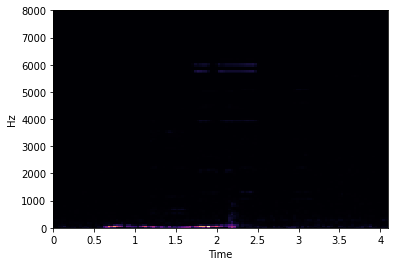

In [45]:
librosa.display.specshow(scored_samples[0][1].mel, sr=16000, x_axis='time', y_axis='hz')

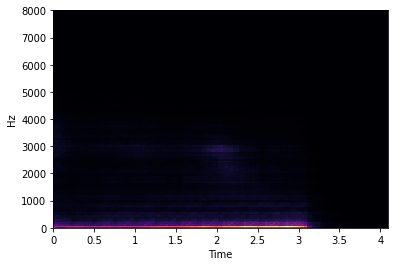

In [22]:
librosa.display.specshow(reconstructions[0], sr=16000, x_axis='time', y_axis='hz')

In [23]:
IPython.display.Audio(scored_samples[1][1].sample, rate=16000)

In [24]:
IPython.display.Audio(scored_samples[2][1].sample, rate=16000)

In [25]:
IPython.display.Audio(scored_samples[3][1].sample, rate=16000)

In [26]:
IPython.display.Audio(scored_samples[4][1].sample, rate=16000)

In [27]:
IPython.display.Audio(scored_samples[5][1].sample, rate=16000)

In [28]:
IPython.display.Audio(scored_samples[6][1].sample, rate=16000)

In [29]:
IPython.display.Audio(scored_samples[7][1].sample, rate=16000)

In [30]:
IPython.display.Audio(scored_samples[8][1].sample, rate=16000)

In [31]:
IPython.display.Audio(scored_samples[9][1].sample, rate=16000)

In [32]:
IPython.display.Audio(scored_samples[10][1].sample, rate=16000)

### Low Scores

In [33]:
IPython.display.Audio(scored_samples[-1][1].sample, rate=16000)

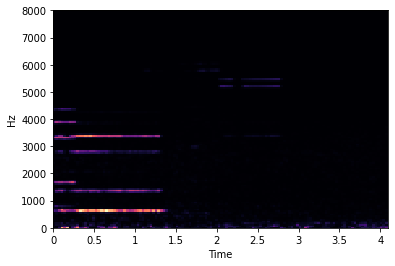

In [34]:
librosa.display.specshow(scored_samples[-1][1].mel, sr=16000, x_axis='time', y_axis='hz')

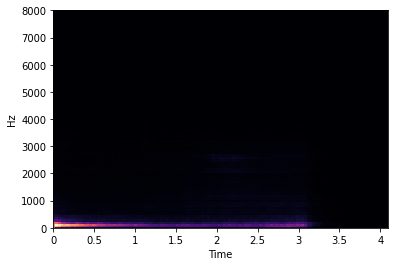

In [35]:
librosa.display.specshow(reconstructions[-1], sr=16000, x_axis='time', y_axis='hz')

In [36]:
IPython.display.Audio(scored_samples[-2][1].sample, rate=16000)

In [37]:
IPython.display.Audio(scored_samples[-3][1].sample, rate=16000)

In [38]:
IPython.display.Audio(scored_samples[-4][1].sample, rate=16000)

In [39]:
IPython.display.Audio(scored_samples[-5][1].sample, rate=16000)

In [40]:
IPython.display.Audio(scored_samples[-6][1].sample, rate=16000)

In [41]:
IPython.display.Audio(scored_samples[-7][1].sample, rate=16000)

In [42]:
IPython.display.Audio(scored_samples[-8][1].sample, rate=16000)

In [43]:
IPython.display.Audio(scored_samples[-9][1].sample, rate=16000)

In [44]:
IPython.display.Audio(scored_samples[-10][1].sample, rate=16000)

In [22]:
scores = []
for i, s in enumerate(samples):
    features = librosa.feature.melspectrogram(y=s, sr=sr, n_fft=1024, hop_length=256)
    features = (features - features.min()) / (features.max() - features.min())
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    outputs = model(features)
    
    loss = loss_fn(outputs, features).item()
    scores.append((i, loss))
scores = sorted(scores, key=lambda x : x[1])

In [27]:
s.min()

-0.036485985

In [11]:
scores

[(13, 0.0007613657508045435),
 (12, 0.0011405345285311341),
 (11, 0.0017651738598942757),
 (7, 0.0018133268458768725),
 (10, 0.002052974421530962),
 (32, 0.00232406216673553),
 (9, 0.0024016001261770725),
 (8, 0.0025628770235925913),
 (31, 0.0027765247505158186),
 (27, 0.002842971356585622),
 (30, 0.002995438175275922),
 (6, 0.0032059955410659313),
 (29, 0.003246042877435684),
 (28, 0.0034053826238960028),
 (3, 0.004472736734896898),
 (26, 0.004718981683254242),
 (14, 0.006228873506188393),
 (2, 0.006462422199547291),
 (24, 0.006846737116575241),
 (1, 0.008014894090592861),
 (15, 0.008051317185163498),
 (41, 0.0098101906478405),
 (0, 0.009924321435391903),
 (39, 0.010106422938406467),
 (40, 0.010764488950371742),
 (23, 0.010869604535400867),
 (34, 0.011729108169674873),
 (25, 0.012726925313472748),
 (33, 0.012835491448640823),
 (38, 0.012888344936072826),
 (5, 0.012927787378430367),
 (4, 0.013349908404052258),
 (35, 0.013758478686213493),
 (20, 0.014595394022762775),
 (22, 0.0146300289

In [14]:
IPython.display.Audio(x, rate=16000)

In [12]:
IPython.display.Audio(x[13*step_size:13*step_size+window_size], rate=16000)